In [1]:
print('hello')

hello


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/harshit/Downloads/Research-Commons-Quant/btc-dataset-metrics-test/dataset/btc.csv', parse_dates=["timestamp"])

In [4]:
# Rename and set index
df = df.rename(columns={"timestamp": "Date", "close": "Close"})
df = df.set_index("Date").sort_index()

In [5]:
# show only close part
df = df[["Close"]]
df

,Close
Date,
2022-07-27,22952.45
2022-07-28,23842.93
2022-07-29,23773.75
2022-07-30,23643.51
2022-07-31,23293.32
...,...
2024-02-18,52137.67
2024-02-19,51774.73
2024-02-20,52258.82


In [6]:
df["LogClose"] = np.log(df["Close"])
df["Return"] = df["Close"].pct_change()
df["LogReturn"] = df["LogClose"].diff()

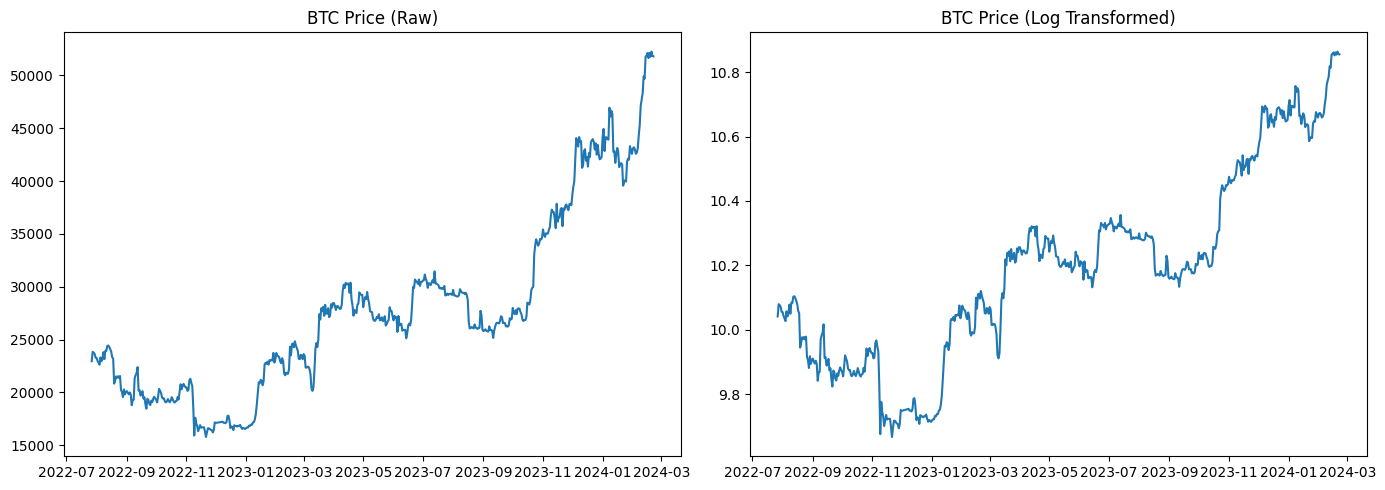

In [7]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(df["Close"])
plt.title("BTC Price (Raw)")

plt.subplot(1, 2, 2)
plt.plot(df["LogClose"])
plt.title("BTC Price (Log Transformed)")
plt.tight_layout()
plt.show()

In [8]:
df["RawReturn"] = df["Close"].pct_change()
df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))

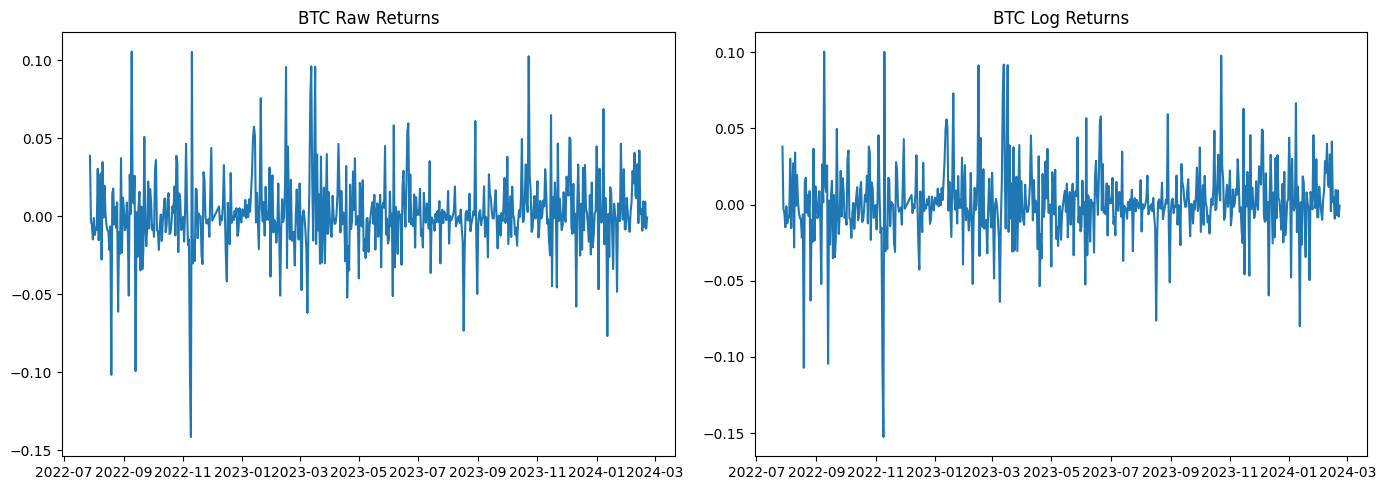

In [9]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(df["RawReturn"])
plt.title("BTC Raw Returns")

plt.subplot(1, 2, 2)
plt.plot(df["LogReturn"])
plt.title("BTC Log Returns")
plt.tight_layout()
plt.show()

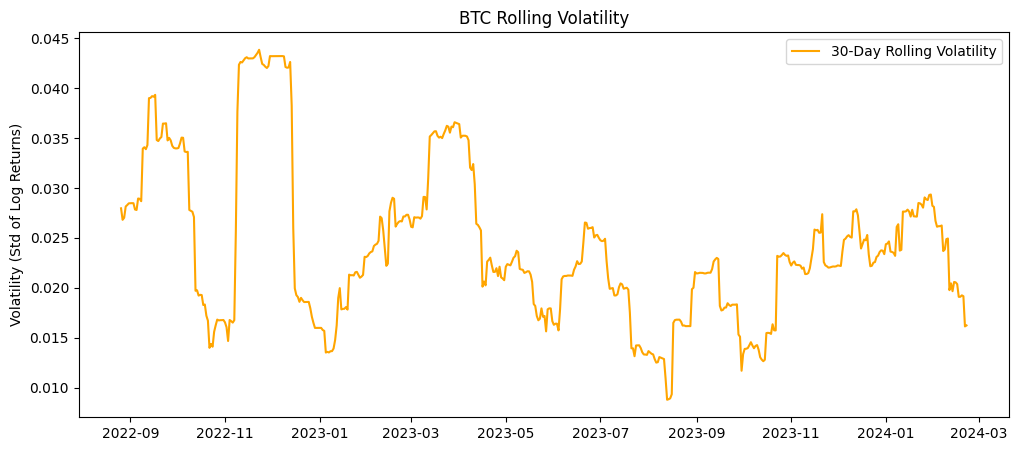

In [10]:
df["RollingVolatility"] = df["LogReturn"].rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(df["RollingVolatility"], label="30-Day Rolling Volatility", color='orange')
plt.title("BTC Rolling Volatility")
plt.ylabel("Volatility (Std of Log Returns)")
plt.legend()
plt.show()


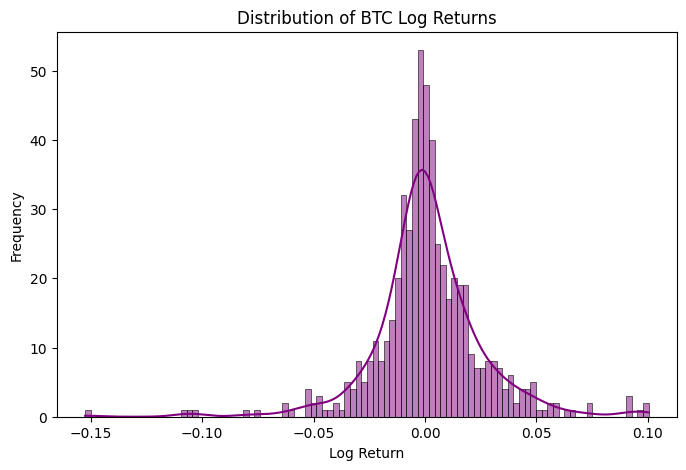

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df["LogReturn"].dropna(), bins=100, kde=True, color="purple")
plt.title("Distribution of BTC Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()

In [12]:
print("Skewness:", df["LogReturn"].skew())
print("Kurtosis:", df["LogReturn"].kurt())

Skewness: -0.247017797912469
Kurtosis: 5.935988229231785


### Basically, finding sharpe & sortino ratio on RAW MARKET DATA if you would've had a long-only BTC portfolio from 2022-2024

In [13]:
# Sharpe Ratio (with 365 days scaling)
sharpe = df["LogReturn"].mean() / df["LogReturn"].std() * np.sqrt(365)

In [14]:
print(sharpe)

1.1006490175688375


In [15]:
# Sortino Ratio (with 365 days scaling)
downside_std = df[df["LogReturn"] < 0]["LogReturn"].std()
sortino = df["LogReturn"].mean() / downside_std * np.sqrt(365)

In [16]:
print(sortino)

1.4659748223808373


In [17]:
# Calculate Cumulative Returns
df["CumulativeReturn"] = (1 + df["LogReturn"]).cumprod()

# Calculate Running Maximum of Cumulative Returns
df["RunningMax"] = df["CumulativeReturn"].cummax()

# Calculate Drawdown
df["Drawdown"] = (df["CumulativeReturn"] - df["RunningMax"]) / df["RunningMax"]

# Max Drawdown is the minimum value in the Drawdown series
max_drawdown = df["Drawdown"].min()

print(f"Max Drawdown: {max_drawdown:.2%}")

Max Drawdown: -39.11%


In [18]:
print(f"Sharpe Ratio (Annualized): {sharpe:.2f}")
print(f"Sortino Ratio (Annualized): {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

Sharpe Ratio (Annualized): 1.10
Sortino Ratio (Annualized): 1.47
Max Drawdown: -39.11%


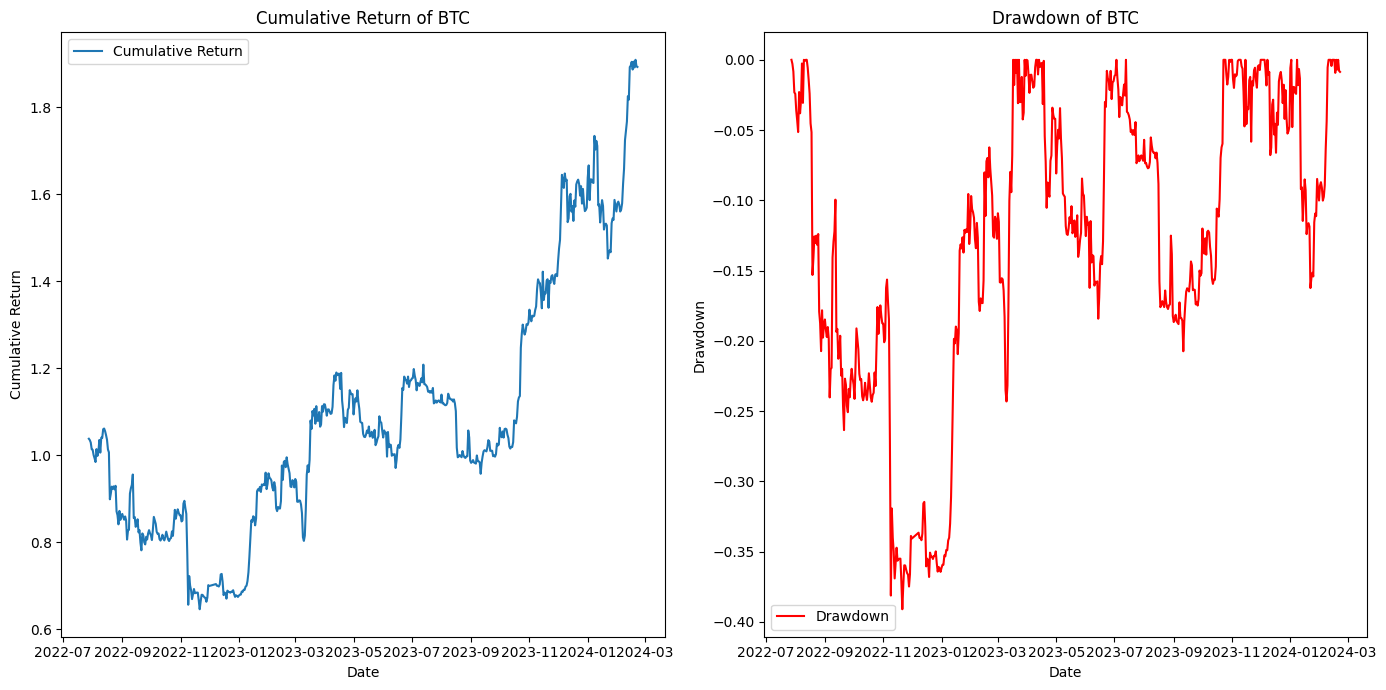

In [19]:
plt.figure(figsize=(14, 7))

# Plot Cumulative Returns
plt.subplot(1, 2, 1)
plt.plot(df["CumulativeReturn"], label="Cumulative Return")
plt.title("Cumulative Return of BTC")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()

# Plot Drawdown
plt.subplot(1, 2, 2)
plt.plot(df["Drawdown"], label="Drawdown", color="red")
plt.title("Drawdown of BTC")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
daily_volatility = df["LogReturn"].std()
print(f"Daily Volatility: {daily_volatility:.2%}")

Daily Volatility: 2.48%


### Forecasting

#### 1. Linear Regression for Price

### 

In [21]:
df

,Close,LogClose,Return,LogReturn,RawReturn,RollingVolatility,CumulativeReturn,RunningMax,Drawdown
Date,,,,,,,,,
2022-07-27,22952.45,10.041180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-28,23842.93,10.079243,0.038797,0.038063,0.038797,NaN,1.038063,1.038063,0.000000
2022-07-29,23773.75,10.076337,-0.002901,-0.002906,-0.002901,NaN,1.035047,1.038063,-0.002906
2022-07-30,23643.51,10.070844,-0.005478,-0.005493,-0.005478,NaN,1.029361,1.038063,-0.008383
2022-07-31,23293.32,10.055922,-0.014811,-0.014922,-0.014811,NaN,1.014001,1.038063,-0.023180
...,...,...,...,...,...,...,...,...,...
2024-02-18,52137.67,10.861643,0.009586,0.009540,0.009586,0.019091,1.904223,1.904223,0.000000
2024-02-19,51774.73,10.854657,-0.006961,-0.006986,-0.006961,0.019238,1.890921,1.904223,-0.006986
2024-02-20,52258.82,10.863964,0.009350,0.009306,0.009350,0.019148,1.908519,1.908519,0.000000


In [22]:
# to change "Date" from index to column
df = df.reset_index()

In [23]:
df

,Date,Close,LogClose,Return,LogReturn,RawReturn,RollingVolatility,CumulativeReturn,RunningMax,Drawdown
0,2022-07-27,22952.45,10.041180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-07-28,23842.93,10.079243,0.038797,0.038063,0.038797,NaN,1.038063,1.038063,0.000000
2,2022-07-29,23773.75,10.076337,-0.002901,-0.002906,-0.002901,NaN,1.035047,1.038063,-0.002906
3,2022-07-30,23643.51,10.070844,-0.005478,-0.005493,-0.005478,NaN,1.029361,1.038063,-0.008383
4,2022-07-31,23293.32,10.055922,-0.014811,-0.014922,-0.014811,NaN,1.014001,1.038063,-0.023180
...,...,...,...,...,...,...,...,...,...,...
565,2024-02-18,52137.67,10.861643,0.009586,0.009540,0.009586,0.019091,1.904223,1.904223,0.000000
566,2024-02-19,51774.73,10.854657,-0.006961,-0.006986,-0.006961,0.019238,1.890921,1.904223,-0.006986
567,2024-02-20,52258.82,10.863964,0.009350,0.009306,0.009350,0.019148,1.908519,1.908519,0.000000
568,2024-02-21,51849.39,10.856098,-0.007835,-0.007866,-0.007835,0.016124,1.893508,1.908519,-0.007866


In [24]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ordinal'] = df['Date'].map(pd.Timestamp.toordinal)

X = df[['Date_ordinal']]
y = df['Close']

In [25]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X, y)

LinearRegression()

In [26]:
y_pred = model.predict(X)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Date'], y, label="Actual Price", color='blue')
plt.plot(df['Date'], y_pred, label="Predicted Price (Linear Regression)", color='red')
plt.legend()
plt.title("BTC Price Prediction using Linear Regression")
plt.xlabel("Date")
plt.ylabel("BTC Price (USDT)")
plt.show()

In [ ]:
# Create 30 future dates
future_dates = pd.date_range(start=df['Date'].max() + pd.Timedelta(days=1), periods=30)

# Convert them to ordinal format
future_dates_ordinal = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)

In [ ]:
future_preds = model.predict(future_dates_ordinal)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


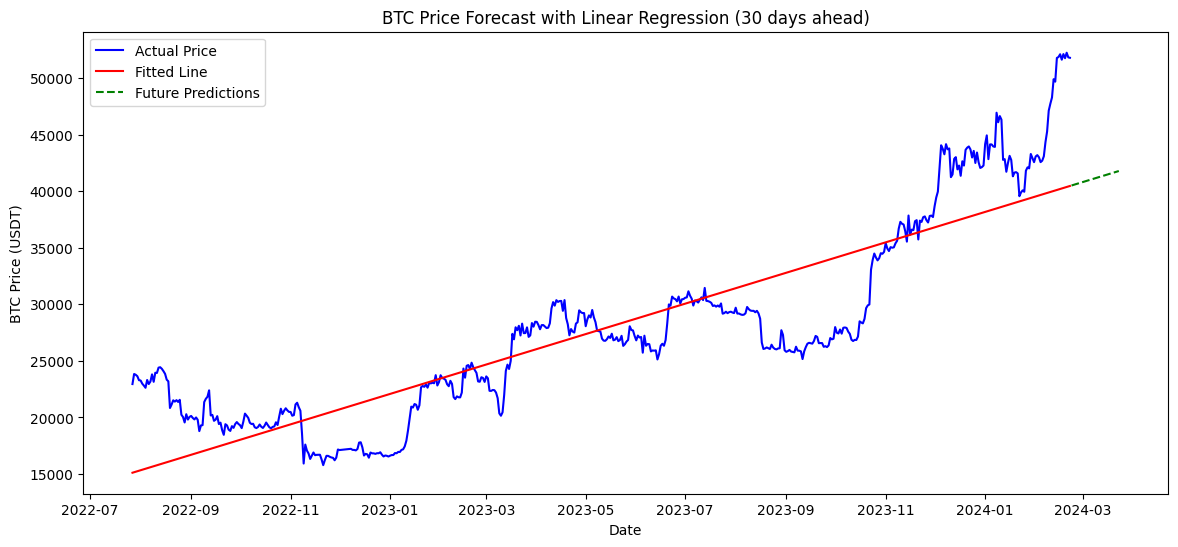

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], y, label="Actual Price", color='blue')
plt.plot(df['Date'], y_pred, label="Fitted Line", color='red')
plt.plot(future_dates, future_preds, label="Future Predictions", color='green', linestyle='--')
plt.legend()
plt.title("BTC Price Forecast with Linear Regression (30 days ahead)")
plt.xlabel("Date")
plt.ylabel("BTC Price (USDT)")
plt.show()

##### Observation:
- Linear Regression is super naive here
- The model just extends a straight line into the future — real BTC prices don't behave like that

--- This was done just for basic understanding

#### 2. Moving Average Forecast

##### Intuition
- moving average forecasting assumes prices stay ready at the recent average
- better than random, but still very simple

In [ ]:
# 7-day moving average (you can change window to 14, 30 etc.)
df["MA7"] = df["Close"].rolling(window=7).mean()

In [ ]:
# Get the last moving average value
last_ma = df["MA7"].dropna().iloc[-1]

# Predict next 30 days with the last moving average value
future_preds_ma = np.full(30, last_ma)

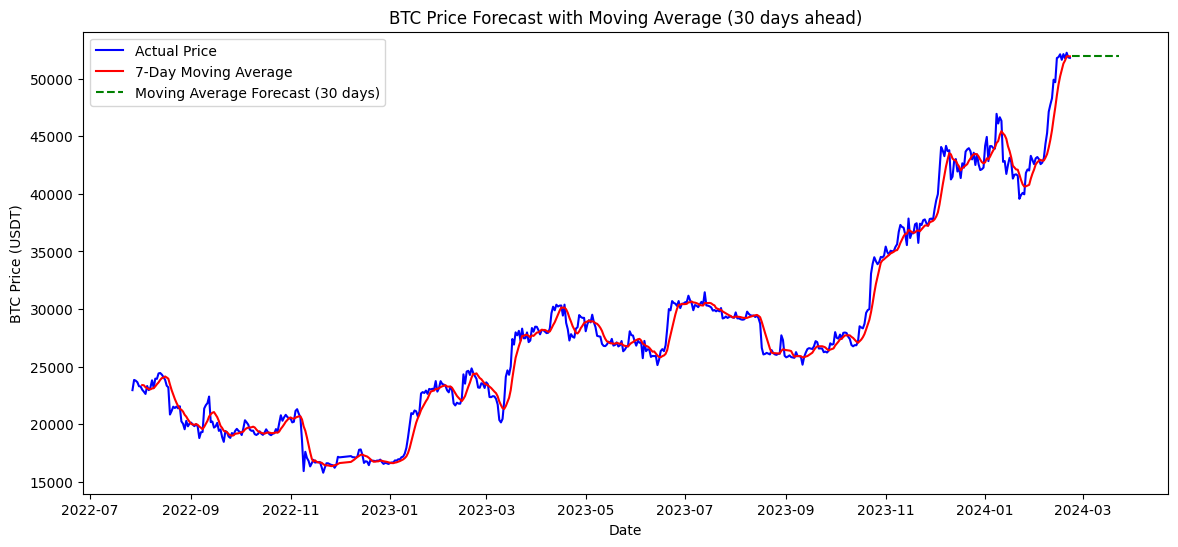

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df["Close"], label="Actual Price", color='blue')
plt.plot(df['Date'], df["MA7"], label="7-Day Moving Average", color='red')
plt.plot(future_dates, future_preds_ma, label="Moving Average Forecast (30 days)", color='green', linestyle='--')
plt.legend()
plt.title("BTC Price Forecast with Moving Average (30 days ahead)")
plt.xlabel("Date")
plt.ylabel("BTC Price (USDT)")
plt.show()

#### 3. Moving average + Drift

In [ ]:
"""Whats Drift ?
--- Instead of assuming the future price will stay flat at the moving average, we also account for the recent trend (slope).

Example: If BTC has been going up 0.5% per day, your forecast should continue rising by +0.5% daily.
"""

'Whats Drift ?\n--- Instead of assuming the future price will stay flat at the moving average, we also account for the recent trend (slope).\n\nExample: If BTC has been going up 0.5% per day, your forecast should continue rising by +0.5% daily.\n'

In [ ]:
# Calculate the daily drift (simple way)
recent_days = 7  # look back 7 days
drift = (df["Close"].iloc[-1] - df["Close"].iloc[-recent_days]) / recent_days

In [ ]:
# Now forecast with both MA and drift
future_preds_drift = future_preds_ma + np.arange(1, 31) * drift

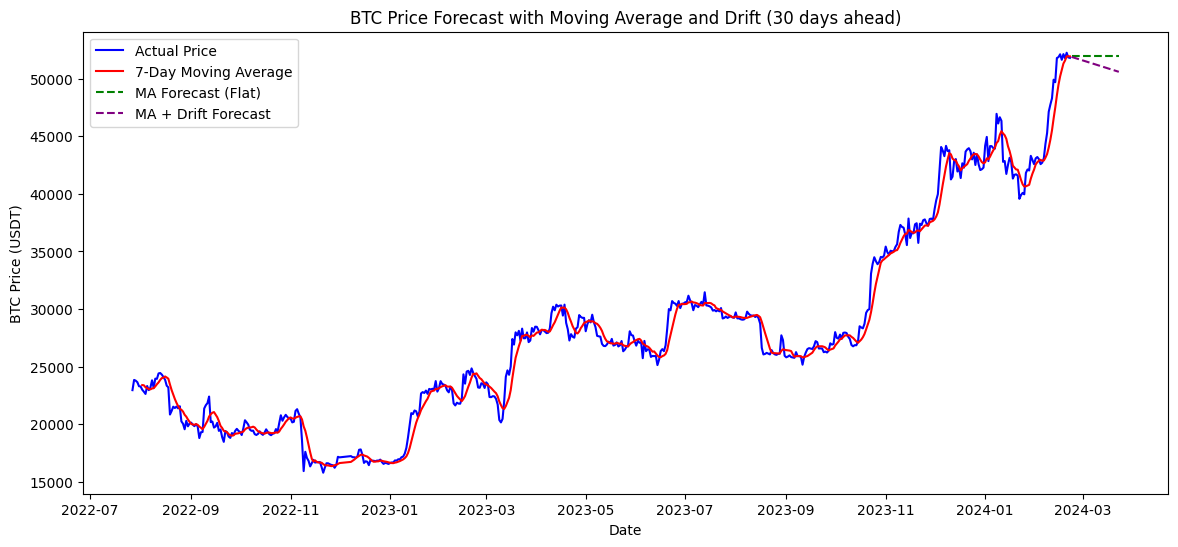

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df["Close"], label="Actual Price", color='blue')
plt.plot(df['Date'], df["MA7"], label="7-Day Moving Average", color='red')
plt.plot(future_dates, future_preds_ma, label="MA Forecast (Flat)", color='green', linestyle='--')
plt.plot(future_dates, future_preds_drift, label="MA + Drift Forecast", color='purple', linestyle='--')
plt.legend()
plt.title("BTC Price Forecast with Moving Average and Drift (30 days ahead)")
plt.xlabel("Date")
plt.ylabel("BTC Price (USDT)")
plt.show()

#### 5. Linear regression with Time as X-Axis

In [ ]:
# Set X as days since start (numeric)
df["Days"] = np.arange(len(df))

# Feature (input)
X = df["Days"].values.reshape(-1, 1)

# Target (output)
y = df["Close"].values

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X, y)

LinearRegression()

In [ ]:
# Predict in-sample (on existing data)
y_pred = model.predict(X)

# Now predict 30 days into the future
future_days = np.arange(len(df), len(df) + 30).reshape(-1, 1)
future_prices = model.predict(future_days)

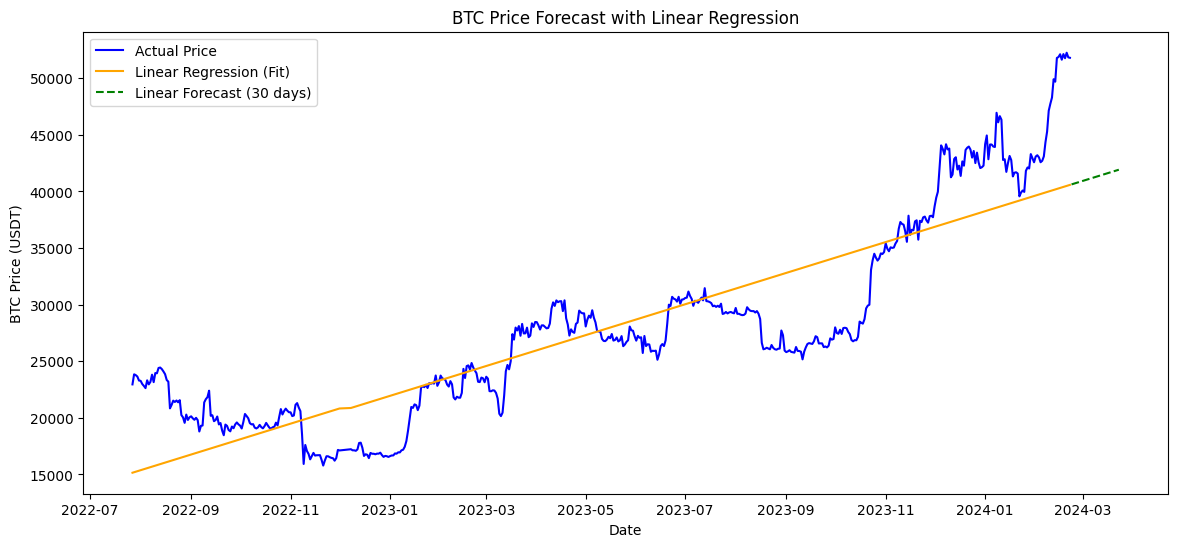

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Close"], label="Actual Price", color='blue')
plt.plot(df["Date"], y_pred, label="Linear Regression (Fit)", color='orange')
plt.plot(pd.date_range(df["Date"].iloc[-1], periods=31, freq="D")[1:], future_prices, 
         label="Linear Forecast (30 days)", color='green', linestyle='--')
plt.legend()
plt.title("BTC Price Forecast with Linear Regression")
plt.xlabel("Date")
plt.ylabel("BTC Price (USDT)")
plt.show()

#### 6. Linear Regression for Returns

In [ ]:
# Create lagged features (previous day's returns)
df['Lag1'] = df['LogReturn'].shift(1)
df['Lag2'] = df['LogReturn'].shift(2)
df['Lag3'] = df['LogReturn'].shift(3)

# Drop NaN values (first 3 rows will have NaN due to shifting)
df = df.dropna()

# Split data into training and testing sets
train = df[:int(0.8 * len(df))]
test = df[int(0.8 * len(df)):]

# Features and target
X_train = train[['Lag1', 'Lag2', 'Lag3']]
y_train = train['LogReturn']
X_test = test[['Lag1', 'Lag2', 'Lag3']]
y_test = test['LogReturn']


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")


RMSE: 0.023841681415720056


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


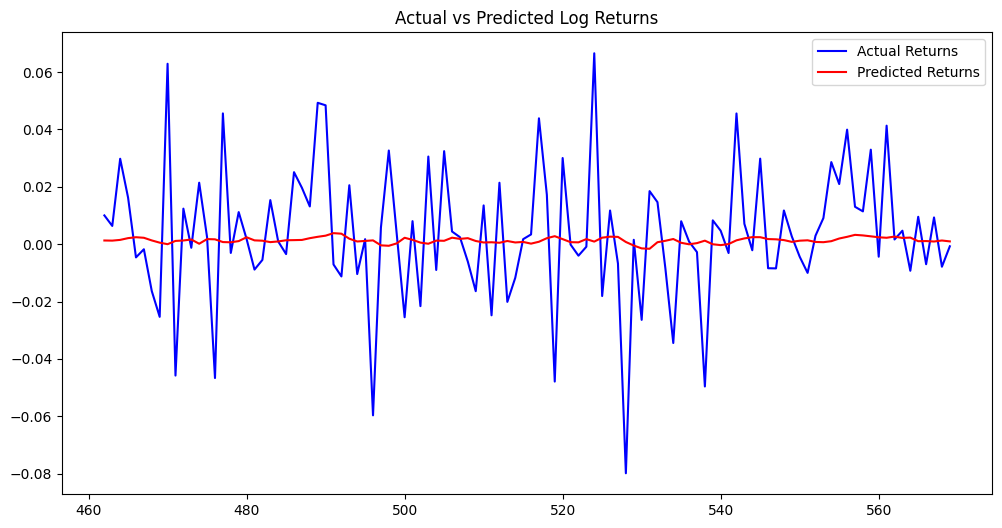

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted log returns
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Returns', color='red')
plt.title('Actual vs Predicted Log Returns')
plt.legend()
plt.show()

#### 7. ARIMA (AutoRegressive Integrated Moving Average)

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on log returns
result = adfuller(df['LogReturn'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -23.45013638954973
p-value: 0.0


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (order (p,d,q)) where:
# p = number of lag observations (AR)
# d = number of times series is differenced (I)
# q = size of moving average (MA)
model = ARIMA(df['LogReturn'], order=(1, 0, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              LogReturn   No. Observations:                  540
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1231.169
Date:                Sat, 26 Apr 2025   AIC                          -2454.339
Time:                        14:59:04   BIC                          -2437.173
Sample:                             0   HQIC                         -2447.625
                                - 540                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.435      0.151      -0.001       0.004
ar.L1          0.6734      1.172      0.575      0.566      -1.624       2.970
ma.L1         -0.6600      1.183     -0.558      0.5

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


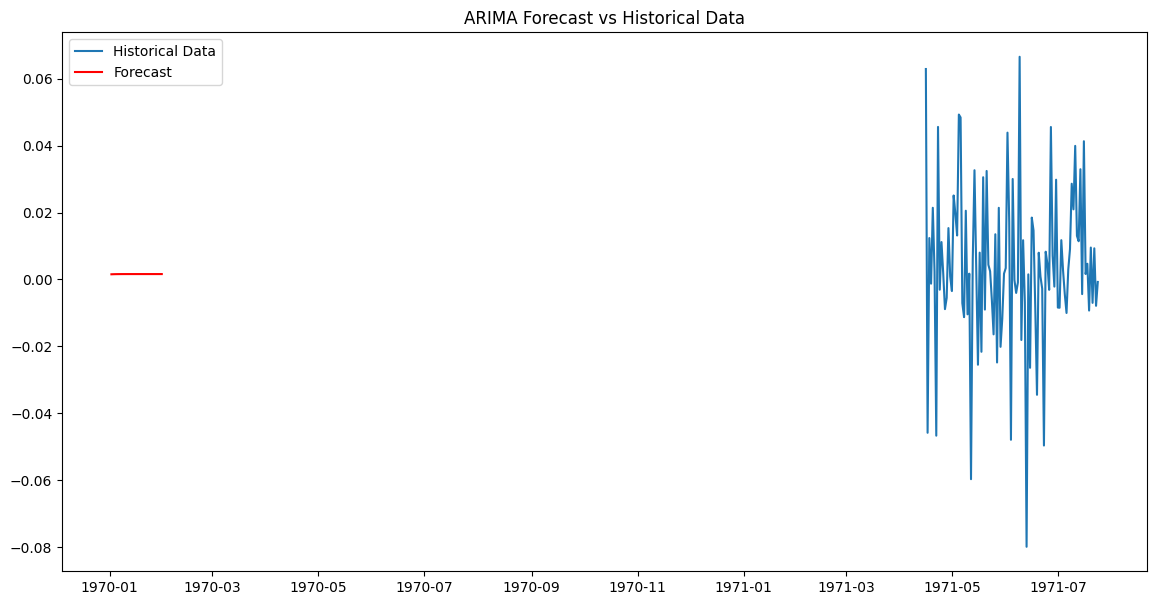

In [ ]:
# Generate forecast for the next 30 days
forecast = model_fit.forecast(steps=30)

# Generate the forecast date range (start from the last date of your data)
forecast_dates = pd.date_range(df.index[-1], periods=31, freq='D')[1:]

# Plot the historical data and forecasted data
plt.figure(figsize=(14, 7))
plt.plot(df.index[-100:], df['LogReturn'].tail(100), label='Historical Data')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Historical Data')
plt.show()